In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [2]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=0)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [3]:
class DNN_7(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_7, self).__init__()
        self.layer1 = nn.Linear(input_dim,32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8, 4)
        self.output_layer = nn.Linear(4, 1)

        self.bn1=nn.BatchNorm1d(32)
        self.bn2=nn.BatchNorm1d(16)
        self.bn3=nn.BatchNorm1d(8)
        self.bn4=nn.BatchNorm1d(4)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn3(self.layer3(x)))

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout2(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [5]:
def objective(trial):
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整

    # モデル定義
    model = DNN_7(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [6]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-18 13:40:10,313] A new study created in memory with name: no-name-de5ae753-0835-4c45-a5f2-cefaf5ce6817


/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:19,227] Trial 0 finished with value: 0.17911912988040762 and parameters: {'dropout1': 0.05, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0004998023072006626, 'weight_decay': 0.010977234032929816}. Best is trial 0 with value: 0.17911912988040762.


Early stopping at epoch 58
Final MCC: 0.1791


/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:28,337] Trial 1 finished with value: 0.08467450519895195 and parameters: {'dropout1': 0.05, 'dropout2': 0.1, 'learning_rate': 0.00012166865974856412, 'weight_decay': 3.77990541875072e-05}. Best is trial 0 with value: 0.17911912988040762.


Early stopping at epoch 69
Final MCC: 0.0847


/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:31,668] Trial 2 finished with value: 0.0 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.15000000000000002, 'learning_rate': 0.018909247161353084, 'weight_decay': 0.0017885820468518825}. Best is trial 0 with value: 0.17911912988040762.


Early stopping at epoch 25
Final MCC: 0.0000


/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:36,945] Trial 3 finished with value: 0.10286443488479152 and parameters: {'dropout1': 0.05, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00044753166584407447, 'weight_decay': 0.0001299201687671525}. Best is trial 0 with value: 0.17911912988040762.


Early stopping at epoch 42
Final MCC: 0.1029


/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:40:41,062] Trial 4 finished with value: 0.24668886377333107 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.25, 'learning_rate': 0.0013407536444163368, 'weight_decay': 2.7243834790406567e-05}. Best is trial 4 with value: 0.24668886377333107.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has be

Early stopping at epoch 30
Final MCC: 0.2467


[I 2024-12-18 13:40:41,336] Trial 6 pruned. 
[I 2024-12-18 13:40:41,498] Trial 7 pruned. 
[I 2024-12-18 13:40:41,639] Trial 8 pruned. 
[I 2024-12-18 13:40:41,776] Trial 9 pruned. 
[I 2024-12-18 13:40:41,925] Trial 10 pruned. 
[I 2024-12-18 13:40:42,083] Trial 11 pruned. 
[I 2024-12-18 13:40:42,249] Trial 12 pruned. 
[I 2024-12-18 13:40:55,120] Trial 13 finished with value: 0.2359336615190247 and parameters: {'dropout1': 0.0, 'dropout2': 0.4, 'learning_rate': 0.00010602017578164849, 'weight_decay': 0.045169495719233704}. Best is trial 4 with value: 0.24668886377333107.


Final MCC: 0.2359


/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:07,722] Trial 14 finished with value: 0.3143000946489379 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'learning_rate': 0.00011129207599932848, 'weight_decay': 0.09859505764834975}. Best is trial 14 with value: 0.3143000946489379.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3

Final MCC: 0.3143


[I 2024-12-18 13:41:08,035] Trial 16 pruned. 
[I 2024-12-18 13:41:18,897] Trial 17 finished with value: 0.11229042229326915 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.45, 'learning_rate': 0.00024398971581418983, 'weight_decay': 0.0035402608044766853}. Best is trial 14 with value: 0.3143000946489379.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:19,066] Tri

Early stopping at epoch 83
Final MCC: 0.1123


[I 2024-12-18 13:41:31,396] Trial 19 finished with value: 0.23763319825314866 and parameters: {'dropout1': 0.25, 'dropout2': 0.2, 'learning_rate': 0.00020912176367090114, 'weight_decay': 4.837284295308193e-05}. Best is trial 14 with value: 0.3143000946489379.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:31,564] Trial 20 pruned. 


Final MCC: 0.2376


[I 2024-12-18 13:41:44,527] Trial 21 finished with value: 0.23806625464787998 and parameters: {'dropout1': 0.2, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0002127555248041934, 'weight_decay': 3.632803719463078e-05}. Best is trial 14 with value: 0.3143000946489379.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:44,670] Trial 22 pruned. 


Final MCC: 0.2381


[I 2024-12-18 13:41:44,823] Trial 23 pruned. 
[I 2024-12-18 13:41:49,393] Trial 24 finished with value: 0.1271868203084939 and parameters: {'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.0007928699757707681, 'weight_decay': 2.164161491387143e-05}. Best is trial 14 with value: 0.3143000946489379.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:41:49,565] Trial 25 pruned. 


Early stopping at epoch 34
Final MCC: 0.1272


[I 2024-12-18 13:41:49,727] Trial 26 pruned. 
[I 2024-12-18 13:41:49,866] Trial 27 pruned. 
[I 2024-12-18 13:41:49,995] Trial 28 pruned. 
[I 2024-12-18 13:41:50,156] Trial 29 pruned. 
[I 2024-12-18 13:41:50,336] Trial 30 pruned. 
[I 2024-12-18 13:42:01,142] Trial 31 finished with value: 0.27331041511137266 and parameters: {'dropout1': 0.25, 'dropout2': 0.2, 'learning_rate': 0.00015893124481708329, 'weight_decay': 4.732591416845096e-05}. Best is trial 14 with value: 0.3143000946489379.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releas

Early stopping at epoch 84
Final MCC: 0.2733


[I 2024-12-18 13:42:01,445] Trial 33 pruned. 
[I 2024-12-18 13:42:01,601] Trial 34 pruned. 
[I 2024-12-18 13:42:08,522] Trial 35 finished with value: 0.24420536271552234 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'learning_rate': 0.0005022562590569632, 'weight_decay': 5.85834094648609e-05}. Best is trial 14 with value: 0.3143000946489379.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1

Early stopping at epoch 53
Final MCC: 0.2442


[I 2024-12-18 13:42:08,833] Trial 37 pruned. 
[I 2024-12-18 13:42:09,009] Trial 38 pruned. 
[I 2024-12-18 13:42:09,165] Trial 39 pruned. 
[I 2024-12-18 13:42:09,321] Trial 40 pruned. 
[I 2024-12-18 13:42:09,478] Trial 41 pruned. 
[I 2024-12-18 13:42:09,622] Trial 42 pruned. 
[I 2024-12-18 13:42:09,786] Trial 43 pruned. 
[I 2024-12-18 13:42:09,945] Trial 44 pruned. 
[I 2024-12-18 13:42:10,099] Trial 45 pruned. 
[I 2024-12-18 13:42:10,262] Trial 46 pruned. 
[I 2024-12-18 13:42:10,439] Trial 47 pruned. 
[I 2024-12-18 13:42:10,605] Trial 48 pruned. 
[I 2024-12-18 13:42:10,763] Trial 49 pruned. 
[I 2024-12-18 13:42:10,917] Trial 50 pruned. 
[I 2024-12-18 13:42:21,383] Trial 51 finished with value: 0.2317373461012312 and parameters: {'dropout1': 0.25, 'dropout2': 0.2, 'learning_rate': 0.00020340305787890548, 'weight_decay': 4.672700183619207e-05}. Best is trial 14 with value: 0.3143000946489379.


Early stopping at epoch 79
Final MCC: 0.2317


/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-18 13:42:33,554] Trial 52 finished with value: 0.19353433895739833 and parameters: {'dropout1': 0.25, 'dropout2': 0.2, 'learning_rate': 0.00020308627735978472, 'weight_decay': 4.891624459039164e-05}. Best is trial 14 with value: 0.3143000946489379.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated i

Final MCC: 0.1935


[I 2024-12-18 13:42:33,906] Trial 54 pruned. 
[I 2024-12-18 13:42:34,064] Trial 55 pruned. 
[I 2024-12-18 13:42:34,221] Trial 56 pruned. 
[I 2024-12-18 13:42:47,081] Trial 57 finished with value: 0.29348287866923445 and parameters: {'dropout1': 0.2, 'dropout2': 0.25, 'learning_rate': 0.00018326916369832273, 'weight_decay': 0.017939032647829874}. Best is trial 14 with value: 0.3143000946489379.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_logun

Final MCC: 0.2935


[I 2024-12-18 13:42:47,370] Trial 59 pruned. 
[I 2024-12-18 13:42:47,517] Trial 60 pruned. 
[I 2024-12-18 13:42:47,687] Trial 61 pruned. 
[I 2024-12-18 13:42:47,840] Trial 62 pruned. 
[I 2024-12-18 13:42:47,972] Trial 63 pruned. 
[I 2024-12-18 13:42:48,126] Trial 64 pruned. 
[I 2024-12-18 13:42:48,295] Trial 65 pruned. 
[I 2024-12-18 13:43:01,092] Trial 66 finished with value: 0.26472922149477224 and parameters: {'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.00012850226354947007, 'weight_decay': 0.022510441884434414}. Best is trial 14 with value: 0.3143000946489379.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v

Final MCC: 0.2647


[I 2024-12-18 13:43:01,386] Trial 68 pruned. 
[I 2024-12-18 13:43:01,543] Trial 69 pruned. 
[I 2024-12-18 13:43:01,711] Trial 70 pruned. 
[I 2024-12-18 13:43:01,862] Trial 71 pruned. 
[I 2024-12-18 13:43:02,035] Trial 72 pruned. 
[I 2024-12-18 13:43:02,189] Trial 73 pruned. 
[I 2024-12-18 13:43:02,340] Trial 74 pruned. 
[I 2024-12-18 13:43:02,507] Trial 75 pruned. 
[I 2024-12-18 13:43:02,662] Trial 76 pruned. 
[I 2024-12-18 13:43:06,242] Trial 77 finished with value: 0.0 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'learning_rate': 0.0013001577395326074, 'weight_decay': 0.07224549714286395}. Best is trial 14 with value: 0.3143000946489379.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2

Early stopping at epoch 27
Final MCC: 0.0000


[I 2024-12-18 13:43:06,560] Trial 79 pruned. 
[I 2024-12-18 13:43:06,706] Trial 80 pruned. 
[I 2024-12-18 13:43:06,853] Trial 81 pruned. 
[I 2024-12-18 13:43:07,032] Trial 82 pruned. 
[I 2024-12-18 13:43:07,175] Trial 83 pruned. 
[I 2024-12-18 13:43:08,579] Trial 84 finished with value: 0.0 and parameters: {'dropout1': 0.05, 'dropout2': 0.2, 'learning_rate': 0.00012117868531356186, 'weight_decay': 0.0464188453005842}. Best is trial 14 with value: 0.3143000946489379.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41908/2804199339.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

Early stopping at epoch 10
Final MCC: 0.0000


[I 2024-12-18 13:43:08,889] Trial 86 pruned. 
[I 2024-12-18 13:43:09,053] Trial 87 pruned. 
[I 2024-12-18 13:43:09,224] Trial 88 pruned. 
[I 2024-12-18 13:43:09,398] Trial 89 pruned. 
[I 2024-12-18 13:43:09,559] Trial 90 pruned. 
[I 2024-12-18 13:43:09,714] Trial 91 pruned. 
[I 2024-12-18 13:43:09,896] Trial 92 pruned. 
[I 2024-12-18 13:43:10,057] Trial 93 pruned. 
[I 2024-12-18 13:43:10,219] Trial 94 pruned. 
[I 2024-12-18 13:43:10,375] Trial 95 pruned. 
[I 2024-12-18 13:43:10,530] Trial 96 pruned. 
[I 2024-12-18 13:43:10,683] Trial 97 pruned. 
[I 2024-12-18 13:43:23,384] Trial 98 finished with value: 0.3441936434225538 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0001037865458581933, 'weight_decay': 0.01970501959245381}. Best is trial 98 with value: 0.3441936434225538.
/tmp/ipykernel_41908/2804199339.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github

Final MCC: 0.3442
Best Parameters:  {'dropout1': 0.30000000000000004, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0001037865458581933, 'weight_decay': 0.01970501959245381}
Best Validation F1:  0.3441936434225538


In [7]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_7_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/200], Loss: 0.7020
Epoch [1/200], Train Loss: 0.7020, Val Loss: 0.7113
Epoch [2/200], Loss: 0.6994
Epoch [2/200], Train Loss: 0.6994, Val Loss: 0.6925
Epoch [3/200], Loss: 0.6906
Epoch [3/200], Train Loss: 0.6906, Val Loss: 0.6882
Epoch [4/200], Loss: 0.6862
Epoch [4/200], Train Loss: 0.6862, Val Loss: 0.6840
Epoch [5/200], Loss: 0.6846
Epoch [5/200], Train Loss: 0.6846, Val Loss: 0.6764
Epoch [6/200], Loss: 0.6798
Epoch [6/200], Train Loss: 0.6798, Val Loss: 0.6744
Epoch [7/200], Loss: 0.6780
Epoch [7/200], Train Loss: 0.6780, Val Loss: 0.6682
Epoch [8/200], Loss: 0.6675
Epoch [8/200], Train Loss: 0.6675, Val Loss: 0.6656
Epoch [9/200], Loss: 0.6697
Epoch [9/200], Train Loss: 0.6697, Val Loss: 0.6608
Epoch [10/200], Loss: 0.6684
Epoch [10/200], Train Loss: 0.6684, Val Loss: 0.6565
Epoch [11/200], Loss: 0.6623
Epoch [11/200], Train Loss: 0.6623, Val Loss: 0.6518
Epoch [12/200], Loss: 0.6587
Epoch [12/200], Train Loss: 0.6587, Val Loss: 0.6487
Epoch [13/200], Loss: 0.6504
Epoch

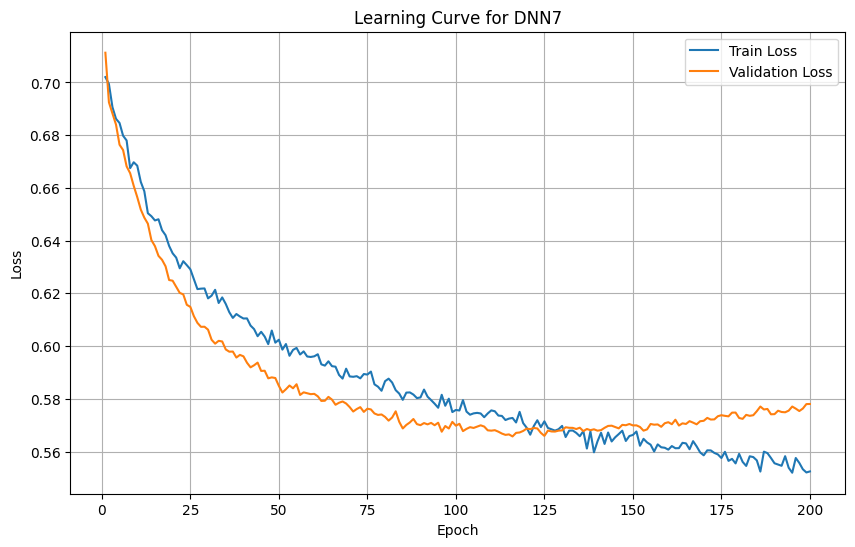

In [14]:
best_params=study.best_params
model = DNN_7(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=200
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN7')
plt.legend()
plt.grid()
plt.show()

Accuracy: 60.36%
Precision: 0.4772
Recall: 0.6728
F1 Score: 0.5584
Matthews Correlation Coefficient: 0.2279
Specificity: 0.5626


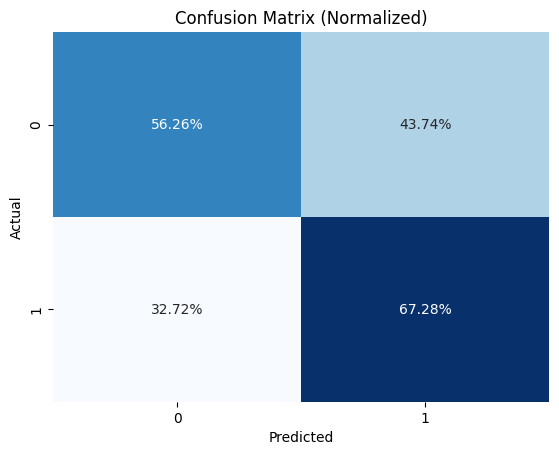

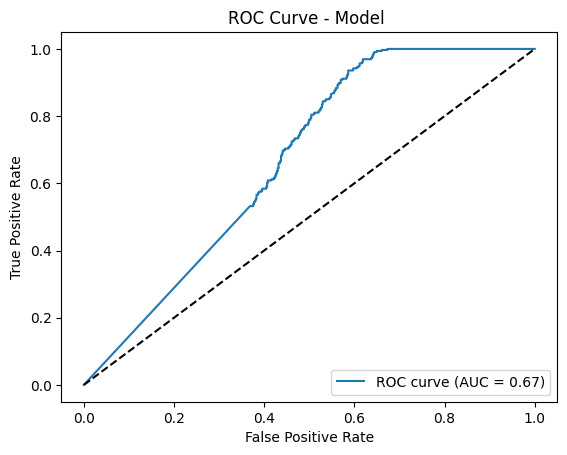

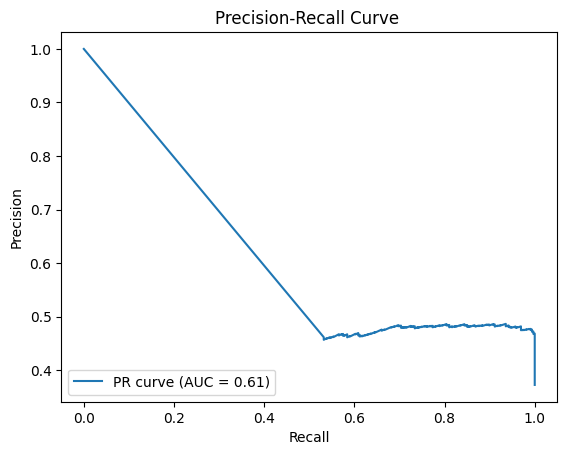

In [15]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [16]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_7.pth')




In [11]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
            Linear-3                   [-1, 16]             528
       BatchNorm1d-4                   [-1, 16]              32
           Dropout-5                   [-1, 16]               0
            Linear-6                    [-1, 8]             136
       BatchNorm1d-7                    [-1, 8]              16
            Linear-8                    [-1, 4]              36
       BatchNorm1d-9                    [-1, 4]               8
          Dropout-10                    [-1, 4]               0
           Linear-11                    [-1, 1]               5
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back